In [1]:
import numpy as np
import fiona
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import xarray as xr

from shapely.geometry import Point, MultiPoint

# Agricultural Land Classification

Agricultural Land Classification data for England can be downloaded here https://data.gov.uk/dataset/952421ec-da63-4569-817d-4d6399df40a1/provisional-agricultural-land-classification-alc.
Data includes England only.

Agricultural land is classified into five grades, with grade one being best quality and grade five is poorest quality. 

We store a low resolution pixelised version of the map using `xarray`, with the resolution in meters being set in  the next cell by the `resolution` parameter.

In [2]:
alc_file = '../../../data/land/ALC/data.gdb/'

# Resolution in meters
resolution = 1000

In [3]:
alc = gpd.read_file(alc_file)
alc

,geogext,ne_ne_admin_ne_agricultural_land_classification_provisional_engl,alc_grade,perimeter,shape_leng,shape_Length,shape_Area,geometry
0,TG2,3712.5350,Grade 1,69726.523,69726.522836,69726.522836,3.712535e+07,"MULTIPOLYGON (((600000.000 229930.000, 599950...."
1,TG2,14694.1436,Grade 2,353091.649,353091.648833,353091.648833,1.469414e+08,"MULTIPOLYGON (((604704.819 233398.524, 604735...."
2,TG2,9606.3941,Grade 3,324491.005,324491.004901,324491.004901,9.606394e+07,"MULTIPOLYGON (((617190.000 232200.000, 617470...."
3,TG2,852.6170,Grade 4,54877.723,54877.722653,54877.722653,8.526171e+06,"MULTIPOLYGON (((602320.000 223580.000, 602370...."
4,TG2,1371.9177,Non Agricultural,95549.247,95549.246390,95549.246390,1.371918e+07,"MULTIPOLYGON (((625490.000 224820.000, 625460...."
...,...,...,...,...,...,...,...,...
1821,,0.0000,Urban,0.000,1107.928675,1107.928675,5.528691e+04,"MULTIPOLYGON (((91404.214 10181.069, 91371.131..."
1822,,0.0000,Grade 4,0.000,973.655847,973.655847,3.987334e+04,"MULTIPOLYGON (((90611.398 11793.825, 90690.773..."
1823,,0.0000,Grade 2,0.000,748.951320,748.951320,3.734471e+04,"MULTIPOLYGON (((89849.310 10091.251, 89854.688..."
1824,,0.0000,Grade 2,0.000,7630.205095,7630.205095,1.559875e+06,"MULTIPOLYGON (((91543.688 10769.655, 91499.399..."


<Axes: >

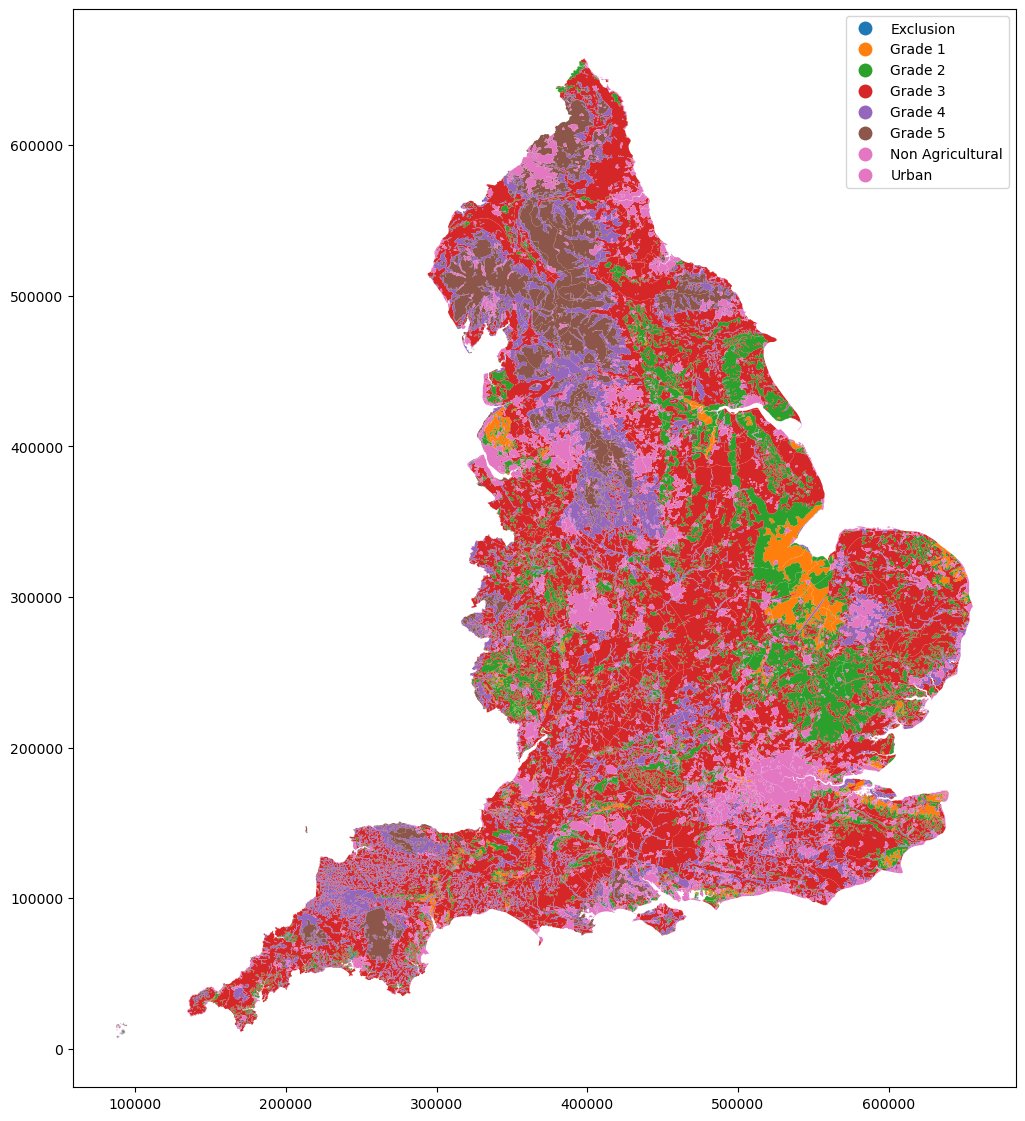

In [4]:
from matplotlib import colors
pltcolors = plt.rcParams['axes.prop_cycle'].by_key()['color']
cmap = colors.ListedColormap(pltcolors[:7])

alc.plot('alc_grade', legend=True, markersize = 1, cmap=cmap, figsize = (14,14))


Find maximum coordinates in EPSG27700 to define the array size

In [5]:
xmin, ymin, xmax, ymax = alc.total_bounds
print(xmin, ymin, xmax, ymax)
# Set minimum values to zero to have a consistent reference point at the origin
size = np.ceil([(xmax)/resolution, (ymax)/resolution]).astype(int)
print(size)

binsx = np.arange(size[0]+1)*resolution 
binsy = np.arange(size[1]+1)*resolution

# Pixel center coordinates
xcoords = 0.5 * (binsx[1:] + binsx[:-1])
ycoords = 0.5 * (binsy[1:] + binsy[:-1])

86973.66119999997 7058.567399999127 655780.0 657599.5
[656 658]


In [6]:
# Grade dictionary
alc_codes = np.unique(alc['alc_grade'])
code_dict = dict(zip(alc_codes, np.arange(len(alc_codes))))
print(code_dict)

{'Exclusion': 0, 'Grade 1': 1, 'Grade 2': 2, 'Grade 3': 3, 'Grade 4': 4, 'Grade 5': 5, 'Non Agricultural': 6, 'Urban': 7}


Generate an empty dataframe with the positions of the pixels and an identifying index

In [7]:
# Fill the grid positions and indexes
xxpos = np.tile(xcoords, len(ycoords))
ix = np.tile(np.arange(size[0]), size[1])
yypos = np.repeat(ycoords, len(xcoords))
iy = np.repeat(np.arange(size[1]), size[0])

In [8]:
df = pd.DataFrame({'xpos':ix, 'ypos':iy})
df['geometry'] = list(zip(xxpos,yypos))
df['geometry'] = df['geometry'].apply(Point)

points = gpd.GeoDataFrame(df, crs='EPSG:27700')
points

,xpos,ypos,geometry
0,0,0,POINT (500.000 500.000)
1,1,0,POINT (1500.000 500.000)
2,2,0,POINT (2500.000 500.000)
3,3,0,POINT (3500.000 500.000)
4,4,0,POINT (4500.000 500.000)
...,...,...,...
431643,651,657,POINT (651500.000 657500.000)
431644,652,657,POINT (652500.000 657500.000)
431645,653,657,POINT (653500.000 657500.000)
431646,654,657,POINT (654500.000 657500.000)


For each point in the grid dataframe, find which ALC grade it falls in.
Points not assigned to any grade will not be added, and remain unassigned on the final array

In [9]:
# pointInPolys = gpd.tools.sjoin(points, alc_final, op="within", how='inner')
pointInPolys = gpd.tools.sjoin(points, alc, predicate="within", how='inner')
pointInPolys['grade'] = np.array([code_dict[g] for g in pointInPolys['alc_grade']])
pointInPolys

,xpos,ypos,geometry,index_right,geogext,ne_ne_admin_ne_agricultural_land_classification_provisional_engl,alc_grade,perimeter,shape_leng,shape_Length,shape_Area,grade
4680,88,7,POINT (88500.000 7500.000),1787,,0.0000,Grade 5,0.000,2592.465213,2592.465213,2.825282e+05,5
6650,90,10,POINT (90500.000 10500.000),1819,,0.0000,Urban,0.000,6775.403586,6775.403586,5.423560e+05,7
6651,91,10,POINT (91500.000 10500.000),1809,,0.0000,Grade 4,0.000,9545.247025,9545.247025,1.548353e+06,4
7307,91,11,POINT (91500.000 11500.000),1809,,0.0000,Grade 4,0.000,9545.247025,9545.247025,1.548353e+06,4
7963,91,12,POINT (91500.000 12500.000),1809,,0.0000,Grade 4,0.000,9545.247025,9545.247025,1.548353e+06,4
...,...,...,...,...,...,...,...,...,...,...,...,...
390025,361,594,POINT (361500.000 594500.000),1148,54,24186.9669,Non Agricultural,215868.818,215868.818337,215868.818337,2.418697e+08,6
390027,363,594,POINT (363500.000 594500.000),1148,54,24186.9669,Non Agricultural,215868.818,215868.818337,215868.818337,2.418697e+08,6
390681,361,595,POINT (361500.000 595500.000),1148,54,24186.9669,Non Agricultural,215868.818,215868.818337,215868.818337,2.418697e+08,6
390682,362,595,POINT (362500.000 595500.000),1148,54,24186.9669,Non Agricultural,215868.818,215868.818337,215868.818337,2.418697e+08,6


In [10]:
grades = np.ones(size)*np.nan
grades = grades.T
# Fill the array with the grades on the corresponding index
grades[tuple([pointInPolys['ypos'], pointInPolys['xpos']])] = pointInPolys['grade']

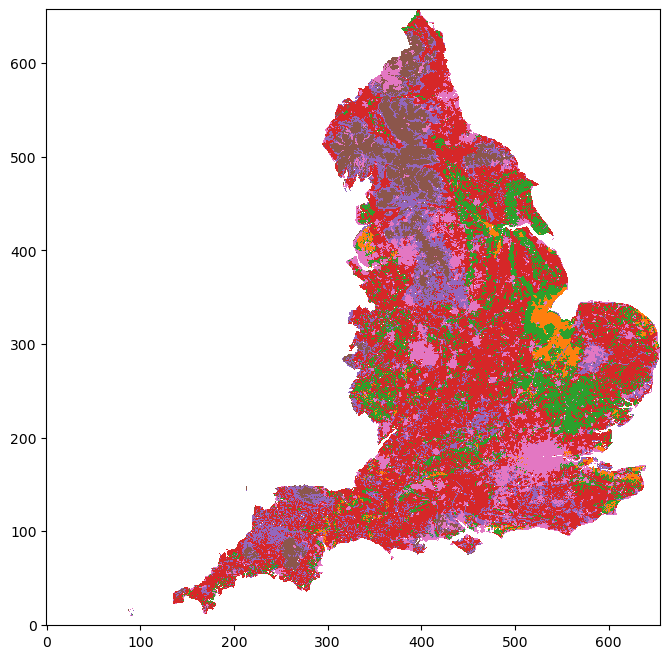

In [11]:
# Plot the rasterised data.
plt.figure(figsize=(10,8))
plt.imshow(grades, interpolation='none', origin='lower', cmap=cmap)

In [12]:
# Create xarray dataset

data = xr.Dataset(
    data_vars = dict(grade=(["y", "x"], grades)),
    coords = dict(y=("y", ycoords), x=("x", xcoords)),
    attrs = code_dict
    )

data

<xarray.Dataset>
Dimensions:  (y: 658, x: 656)
Coordinates:
  * y        (y) float64 500.0 1.5e+03 2.5e+03 ... 6.555e+05 6.565e+05 6.575e+05
  * x        (x) float64 500.0 1.5e+03 2.5e+03 ... 6.535e+05 6.545e+05 6.555e+05
Data variables:
    grade    (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
Attributes:
    Exclusion:         0
    Grade 1:           1
    Grade 2:           2
    Grade 3:           3
    Grade 4:           4
    Grade 5:           5
    Non Agricultural:  6
    Urban:             7

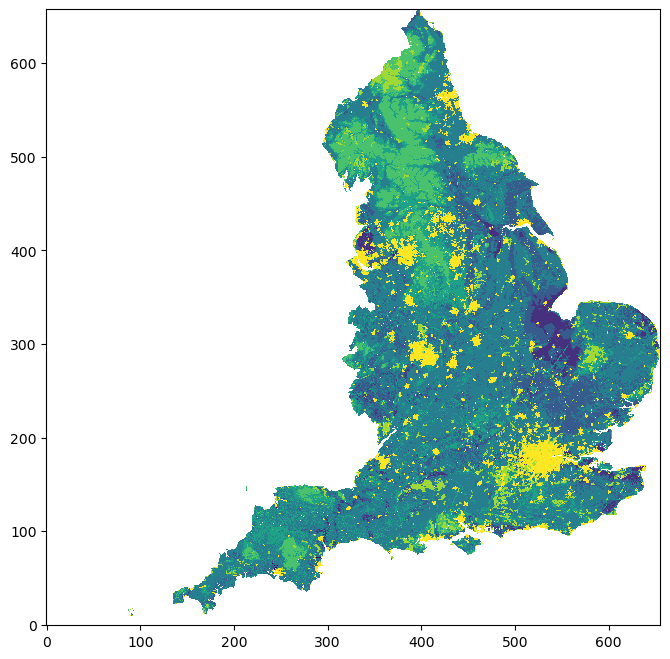

In [13]:
# Plot from the generated dataset

plt.figure(figsize=(10,8))
plt.imshow(data.grade, interpolation='none', origin='lower')

In [14]:
# Save to file

encoding = {"grade":{"dtype":"float32", "zlib": True, "complevel": 5}}
data.to_netcdf(f"../data/NaturalEngland_ALC_{resolution}.nc", encoding=encoding)